
# Is the location of a school and the amount of funding it receives related to outcomes for the school and its pupils? 

Central funding committed to schools for the 2022/23 financial year in England was around £53.8 billion (Ogden et al., 2022). The majority of this funding is allocated to schools per pupil on roll, with additional funding calculated based on several measures of pupil disadvantage, such as the number of pupils eligible for free school meals (FSM), with low prior attainment or English as an additional language (EAL). Additional funding is also allocated to schools that are small, and those that are seeing substantial increases in their pupil numbers. 

Last year, a paper prepared for the Child of the North All-party Parliamentary Group (APPG) presented key findings around schools in the North of England receiving less funding, on average, than schools in the South (Mon-Williams et al., 2023). The paper related this inequality to poorer outcomes for children and young people, including higher school absence rates, poorer educational attainment, and worse physical and mental health. 


Hypotheses
1. There will be a relationship between the location of a school in England and the amount of funding it recieves per pupil. Specifically, the further North a school is located, the less funding it will receive in average. 
2. There will be a negative relationship between the amount of funding a school receives per pupil and both school performance (Ofsted rating) and pupil performance (school absence rate). 


## Measures 

### Independent variable: School Location
I will use two different variable to examine the effect of school location: 
- Easting and Northing coordinates will provide the exact location of each school in England. The Northing coordinate represents how far North a location is in metres. 
- Rural/Urban Classification of an area indicates how densly populated it is on a 10 point scale. The Classification defines areas as rural if they fall outside of settlements with more than 10,000 resident population.
https://www.gov.uk/government/collections/rural-urban-classification 

### Independent variable: School Funding
The main variable considered in the allocation of funding to schools in the number of pupils on roll. As school sizes vary significantly, I will use a measure of funding per pupil derived from the total school funding allocated across all pupils on roll.


### Pupil Outcome: Absences
I will look at absences rates as an important outcome for pupils. School attendance is a good indicator of young people's engagement with education and is strongly associated with other important outcomes including GCSE grades and successful transitions to further education and employment (REFERENCE). 

### School Outcome: Ofsted rating
The performance measure I will use for schools is Ofsted rating. The Office for Standards in Education, Children's Services and Skills (Ofsted) is primarily responsible for assessing the quality of education and care provided by schools across the UK. There is a 4-point scale for Ofsted ratings - grade 1: outstanding, grade 2: good, grade 3: requires improvement and grade 4: inadequate/serious weaknesses. The rating that a school receives from Ofsted can have a big impact on whether parents choose to enrol their children, on staff morale, and even on the funding that the school receives.

### Other variables included
A couple of additional variables will be included as a means of validating/contextualising any findings as they are known to have an influence on school funding and pupil outcomes. 
- Free School Meals (FSM): I will include the proportion of pupils on a school roll who are eligible for FSM. In England, children are eligible for FSM if their parents are receiving benefits, so this is one of the main deprivtion indicators used to calculate a schools allocation of funding. Eligiblity for FSM has also been linked in the research to poorer attendance rates. 
- School Phase: The majority of school funding is calculated per pupil on roll, and the base amount varies by key stage - increasing as children get older. This means that we would expect Secondary schools to receive more funding per pupil on average than primary schools. 
- Regional School Commissioner (RSC): I will include this variable as an 'at-a-glance' indicator of the area of England schools are located in.




Mon-Williams, M., Wood, M. L., et al. (2023). Addressing Education and Health Inequity: Perspectives from the North of England. A report prepared for the Child of the North APPG 

K. Ogden, D. Phillips, L. Sibieta, M. Warner and B. Zaranko, “Does funding follow need? An analysis of the geographic distribution of public spending in England,” The Insitute for Fiscal Studies, 2022.


In [618]:
# import required packages
import pandas as pd
import numpy as np

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from pyod.models.ecod import ECOD
from scipy import stats

# hide formatting warning
import warnings
warnings.filterwarnings('ignore')

# Stage 1: Preparing the data

The first step is to create a dataframe with all of the relevant data. This will involve joining school level data taken from three separate files, using the school unique reference number (URN), common to all three data sets:
- The main file contains the Ofsted rating and easting, northing coordinates for all schools in the UK correct at the time of accessing the data (24/01/2024). Retrieved from https://get-information-schools.service.gov.uk/Downloads. 
- file 2 contains the data on total funding and per pupil funding for all state funded mainstream schools in England for the academic year 2021/22. Retrieved from https://explore-education-statistics.service.gov.uk/find-statistics/school-funding-statistics
- file 3 contains the total, authorised and unauthorised absence rates for each school in England for each academic year between 2016/17 and 2022/23. Retrieved from https://explore-education-statistics.service.gov.uk/find-statistics/pupil-absence-in-schools-in-england/2021-22

All three files are made publicly available by the UK Government and contain routinely collected data held by the Department for Education.  

#### Pre-processing and cleansing steps taken as part of data join:
- Records with missing values for Ofsted rating are removed 
- Removed boarding schools so as not to skew the measure of school absenses
- Absence data is filtered to show records from the 2021/22 academic year only, to align with the available funding data 
- Changed datatypes of columns where appropriate
- removed schools with 0 pupils on roll as anomolies

## Joining the data

### School data

In [2]:
# read in school data (low_memory=False included to remove error)
schools_raw = pd.read_csv('Data/edubasealldata2024.csv', encoding='latin-1', 
                          low_memory=False)
schools_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50684 entries, 0 to 50683
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   URN                               50684 non-null  int64  
 1   LA (code)                         50684 non-null  int64  
 2   LA (name)                         50684 non-null  object 
 3   EstablishmentNumber               50549 non-null  float64
 4   EstablishmentName                 50684 non-null  object 
 5   TypeOfEstablishment (code)        50684 non-null  int64  
 6   TypeOfEstablishment (name)        50684 non-null  object 
 7   EstablishmentTypeGroup (code)     50684 non-null  int64  
 8   EstablishmentTypeGroup (name)     50684 non-null  object 
 9   EstablishmentStatus (code)        50684 non-null  int64  
 10  EstablishmentStatus (name)        50684 non-null  object 
 11  ReasonEstablishmentOpened (code)  50684 non-null  int64  
 12  Reas

In [3]:
# new dataframe with only the colomns of interest
schools = schools_raw.iloc[:,[0, 4, 18, 31, 66, 67, 60, 62, 63, 34, 22]]
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50684 entries, 0 to 50683
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      50684 non-null  int64  
 1   EstablishmentName        50684 non-null  object 
 2   PhaseOfEducation (name)  50684 non-null  object 
 3   NumberOfPupils           29062 non-null  float64
 4   OfstedRating (name)      27603 non-null  object 
 5   RSCRegion (name)         47718 non-null  object 
 6   UrbanRural (name)        49265 non-null  object 
 7   Easting                  48937 non-null  float64
 8   Northing                 48937 non-null  float64
 9   PercentageFSM            28852 non-null  float64
 10  Boarders (name)          50684 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 4.3+ MB


In [4]:
# drop records with null values for Ofsted rating as this will be used later
schools = schools.dropna(subset = 'OfstedRating (name)')
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27603 entries, 4 to 49086
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      27603 non-null  int64  
 1   EstablishmentName        27603 non-null  object 
 2   PhaseOfEducation (name)  27603 non-null  object 
 3   NumberOfPupils           25674 non-null  float64
 4   OfstedRating (name)      27603 non-null  object 
 5   RSCRegion (name)         27603 non-null  object 
 6   UrbanRural (name)        27603 non-null  object 
 7   Easting                  27603 non-null  float64
 8   Northing                 27603 non-null  float64
 9   PercentageFSM            25640 non-null  float64
 10  Boarders (name)          27603 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.5+ MB


In [5]:
# check values for boarders
np.unique(schools['Boarders (name)'])

array(['Boarding school', "Children's home (Boarding school)",
       'College / FE residential accommodation', 'No boarders',
       'Not applicable'], dtype=object)

In [6]:
# filter df to only 'no boarders' as school attendance is likely to vary between day and boarding schools
schools = schools.loc[schools['Boarders (name)'] == 'No boarders']
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26206 entries, 4 to 49084
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      26206 non-null  int64  
 1   EstablishmentName        26206 non-null  object 
 2   PhaseOfEducation (name)  26206 non-null  object 
 3   NumberOfPupils           24565 non-null  float64
 4   OfstedRating (name)      26206 non-null  object 
 5   RSCRegion (name)         26206 non-null  object 
 6   UrbanRural (name)        26206 non-null  object 
 7   Easting                  26206 non-null  float64
 8   Northing                 26206 non-null  float64
 9   PercentageFSM            24535 non-null  float64
 10  Boarders (name)          26206 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.4+ MB


In [7]:
# drop boarders column
schools = schools.drop(columns='Boarders (name)')
schools.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM
4,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8
5,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2
7,103617,Skilts School,Not applicable,69.0,Requires improvement,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,409453.0,267757.0,87.0
8,103623,Springfield House Community Special School,Not applicable,85.0,Good,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,420203.0,276193.0,55.3
11,104095,Lady Katherine Leveson Church of England Prima...,Primary,153.0,Requires improvement,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,420750.0,276067.0,25.9


### Funding data

In [8]:
# read in funding allocation data 
funding_raw = pd.read_csv('Data/20230126_School_level_data.csv', 
                          encoding='unicode_escape')
funding_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20177 entries, 0 to 20176
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   LA Code                           20177 non-null  int64  
 1   Local Authority Name              20177 non-null  object 
 2   UKPRN                             20177 non-null  int64  
 3   URN                               20177 non-null  int64  
 4   LAESTAB                           20177 non-null  int64  
 5   Provider Name                     20177 non-null  object 
 6   Estab. Type                       20177 non-null  object 
 7   Phase                             20177 non-null  object 
 8   Basic Entitlement Total Funding   20177 non-null  float64
 9   Deprivation Total Funding         20177 non-null  float64
 10  LAC Total Funding                 20177 non-null  object 
 11  EAL Total Funding                 20177 non-null  float64
 12  Mobi

In [9]:
# new dataframe with only the colomns of interest
funding = funding_raw.iloc[:,[3, 17, 18]]
funding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20177 entries, 0 to 20176
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   URN                   20177 non-null  int64  
 1   Allocation per Pupil  20177 non-null  float64
 2   Total Funding         20177 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 473.0 KB


In [10]:
# merge the two data frames based on school URN
schools_funding = pd.merge(schools, funding, left_on='URN', 
                           right_on='URN', how='inner')
schools_funding.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM,Allocation per Pupil,Total Funding
0,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8,6441.80,510049.0
1,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2,4958.39,1170602.0
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660.0,384721.0,2.8,4265.00,968304.0
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989.0,414229.0,4.3,4296.65,1315619.0
4,106270,St Damian's RC Science College,Secondary,837.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017.0,401424.0,18.4,6060.34,5422860.0


### Absence data

In [11]:
# read in absences data (low_memory=False included to remove error)
absence_raw = pd.read_csv('Data/1_absence_2term_school.csv', 
                          low_memory=False)
absence_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127291 entries, 0 to 127290
Data columns (total 66 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   time_period                     127291 non-null  int64  
 1   time_identifier                 127291 non-null  object 
 2   geographic_level                127291 non-null  object 
 3   country_code                    127291 non-null  object 
 4   country_name                    127291 non-null  object 
 5   region_code                     127291 non-null  object 
 6   region_name                     127291 non-null  object 
 7   old_la_code                     127291 non-null  int64  
 8   new_la_code                     127291 non-null  object 
 9   la_name                         127291 non-null  object 
 10  school_type                     127291 non-null  object 
 11  estab                           127291 non-null  int64  
 12  school_laestab  

In [12]:
# new dataframe with only the colomns of interest
absence = absence_raw.iloc[:,[0, 13, 23]]
absence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127291 entries, 0 to 127290
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time_period           127291 non-null  int64  
 1   school_urn            127291 non-null  int64  
 2   sess_overall_percent  127291 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.9 MB


In [13]:
# check values for time_period
np.unique(absence['time_period'])

array([201617, 201718, 201819, 202021, 202122, 202223])

In [14]:
# keep only records from 2021/21 year (to match the funding data) 
absence_2122 = absence.loc[absence['time_period'] == 202122]
# check this has worked
np.unique(absence_2122['time_period'])

array([202122])

In [510]:
# merge the absence data into the schools_funding dataframe based on school URN
schools = pd.merge(schools_funding, 
                   absence_2122[['school_urn', 'sess_overall_percent']], 
                   left_on='URN', right_on='school_urn', how='inner')
schools.head()

,URN,EstablishmentName,PhaseOfEducation (name),NumberOfPupils,OfstedRating (name),RSCRegion (name),UrbanRural (name),Easting,Northing,PercentageFSM,Allocation per Pupil,Total Funding,school_urn,sess_overall_percent
0,101614,Downe Primary School,Primary,74.0,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350.0,161795.0,10.8,6441.80,510049.0,101614,8.14970
1,102028,Forty Hill CofE Primary School,Primary,227.0,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178.0,198690.0,17.2,4958.39,1170602.0,102028,4.98025
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660.0,384721.0,2.8,4265.00,968304.0,105078,6.27767
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989.0,414229.0,4.3,4296.65,1315619.0,105344,4.72174
4,106270,St Damian's RC Science College,Secondary,837.0,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017.0,401424.0,18.4,6060.34,5422860.0,106270,7.11089


In [511]:
# drop duplicate URN column
schools = schools.drop(columns='school_urn')
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   URN                      18398 non-null  int64  
 1   EstablishmentName        18398 non-null  object 
 2   PhaseOfEducation (name)  18398 non-null  object 
 3   NumberOfPupils           18398 non-null  float64
 4   OfstedRating (name)      18398 non-null  object 
 5   RSCRegion (name)         18398 non-null  object 
 6   UrbanRural (name)        18398 non-null  object 
 7   Easting                  18398 non-null  float64
 8   Northing                 18398 non-null  float64
 9   PercentageFSM            18398 non-null  float64
 10  Allocation per Pupil     18398 non-null  float64
 11  Total Funding            18398 non-null  float64
 12  sess_overall_percent     18398 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.8+ MB


In [512]:
# use dictionary to rename columns to make more accessible
schools = schools.rename(columns={'EstablishmentName': 'School Name', 'PhaseOfEducation (name)': 'Phase', 
                                  'NumberOfPupils': 'Pupils on Roll', 'PercentageFSM': 'FSM Rate',
                                  'OfstedRating (name)': 'Ofsted Rating', 'RSCRegion (name)': 'RSC Region',
                                  'Allocation per Pupil': 'Funding per Pupil', 
                                  'UrbanRural (name)': 'Region Classification',
                                  'sess_overall_percent': 'Total Absence Rate'})

In [513]:
# check the correct columns are present in the final dataframe
# check for missing values and correct datatypes
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URN                    18398 non-null  int64  
 1   School Name            18398 non-null  object 
 2   Phase                  18398 non-null  object 
 3   Pupils on Roll         18398 non-null  float64
 4   Ofsted Rating          18398 non-null  object 
 5   RSC Region             18398 non-null  object 
 6   Region Classification  18398 non-null  object 
 7   Easting                18398 non-null  float64
 8   Northing               18398 non-null  float64
 9   FSM Rate               18398 non-null  float64
 10  Funding per Pupil      18398 non-null  float64
 11  Total Funding          18398 non-null  float64
 12  Total Absence Rate     18398 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.8+ MB


In [514]:
# change data types from 'float' to 'int'
schools[['Pupils on Roll', 
         'Easting', 
         'Northing']] = schools[['Pupils on Roll',
                                 'Easting', 
                                 'Northing']].astype(int)
print(schools.dtypes)

URN                        int64
School Name               object
Phase                     object
Pupils on Roll             int64
Ofsted Rating             object
RSC Region                object
Region Classification     object
Easting                    int64
Northing                   int64
FSM Rate                 float64
Funding per Pupil        float64
Total Funding            float64
Total Absence Rate       float64
dtype: object


In [515]:
# explore the data for any unexpected values
schools.describe()

,URN,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate
count,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,1.839800e+04,18398.000000
mean,125761.782531,407.908142,449515.362105,283091.964996,23.792325,5210.188298,2.224797e+06,6.661978
std,15121.204654,371.006641,85777.387902,128038.911206,14.867939,1070.890882,2.147466e+06,1.938125
min,100000.000000,0.000000,136274.000000,12574.000000,0.000000,4127.110000,2.147650e+05,1.420750
25%,112383.250000,188.000000,389652.750000,177550.500000,12.100000,4434.202500,9.570120e+05,5.448810
50%,124143.500000,278.000000,443492.500000,275115.000000,20.300000,4935.560000,1.433372e+06,6.402860
75%,140317.750000,457.000000,519663.500000,392626.250000,33.000000,5628.357500,2.383251e+06,7.571532
max,148873.000000,2990.000000,654588.000000,654722.000000,87.900000,22225.330000,1.770485e+07,48.377620


In [516]:
# look at records with 0 pupils on roll
schools.loc[schools['Pupils on Roll'] == 0]

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate
824,106414,Abram Bryn Gates Primary School,Primary,0,Requires improvement,Lancashire and West Yorkshire,(England/Wales) Rural town and fringe,359689,401393,0.0,5282.95,899056.0,6.86236
2357,142124,Atrium Studio School,Secondary,0,Good,South-West England,(England/Wales) Rural town and fringe,276365,70904,0.0,11610.00,323327.0,10.49170
3842,121500,Hovingham Church of England Voluntary Controll...,Primary,0,Good,North of England,(England/Wales) Rural village,466719,475620,0.0,12863.50,284090.0,8.17407
12253,100044,St Michael's Church of England Primary School,Primary,0,Good,North-West London and South-Central England,(England/Wales) Urban major conurbation,529204,183886,0.0,7201.80,911443.0,6.70968


In [517]:
# remove these schools as anomolies
schools = schools.loc[schools['Pupils on Roll'] > 0]
schools.describe()

,URN,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate
count,18394.000000,18394.000000,18394.000000,18394.000000,18394.000000,18394.000000,1.839400e+04,18394.000000
mean,125763.574698,407.996847,449524.391378,283091.995705,23.797499,5209.312062,2.225150e+06,6.661675
std,15120.472803,370.998206,85772.549555,128030.343712,14.865414,1068.376634,2.147562e+06,1.938097
min,100000.000000,5.000000,136274.000000,12574.000000,0.000000,4127.110000,2.147650e+05,1.420750
25%,112384.250000,188.000000,389665.500000,177550.500000,12.100000,4434.155000,9.572670e+05,5.448727
50%,124146.500000,278.000000,443492.500000,275115.000000,20.300000,4935.390000,1.434084e+06,6.402500
75%,140317.750000,457.000000,519663.500000,392620.750000,33.000000,5628.322500,2.384276e+06,7.570602
max,148873.000000,2990.000000,654588.000000,654722.000000,87.900000,22225.330000,1.770485e+07,48.377620


### Pre-processing and cleansing

#### Pre-processing and cleansing steps taken after data join: 
School Phase:
- Middle schools are re-classified as Primary or Secondary as appropriate
- One Performing Arts School is removed as a unique case

Ofsted Rating:
- The Ofsted classifications of 'Special Measures' and 'Serious Weaknesses' are consolidated under the classification 'Cause for Concern' due to the similarity between these categories and low numbers of schools with these ratings
- A new column is created for 'Ofsted Score' which allows this variable to be analysed as ordinal

Urban/Rural Classification:
- A new column is created for 'URC Score' which allows this variable to be analysed as ordinal

#### School Phase

In [518]:
# check values and group sizes for phase of education
schools.groupby('Phase').size()

Phase
All-through                  125
Middle deemed primary          7
Middle deemed secondary       83
Not applicable                 1
Primary                    15405
Secondary                   2773
dtype: int64

In [519]:
# re-classify middle schools
schools['Phase'].replace('Middle deemed primary', 'Primary', 
                         inplace=True)
schools['Phase'].replace('Middle deemed secondary', 'Secondary', 
                         inplace=True)
# check its worked
schools.groupby('Phase').size()

Phase
All-through         125
Not applicable        1
Primary           15412
Secondary          2856
dtype: int64

In [520]:
# check the record with phase listed as 'Not applicable'
schools.loc[schools['Phase'] == 'Not applicable']

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate
12947,101849,BRIT School for Performing Arts and Technology,Not applicable,1397,Good,South-East England and South London,(England/Wales) Urban major conurbation,532834,167463,11.3,6372.34,2699072.0,7.79093


In [521]:
# remove this record from the dataframe as an anomoly (FE performing arts school, aged 14-19) 
schools = schools.drop(index=12947)
schools.groupby('Phase').size()

Phase
All-through      125
Primary        15412
Secondary       2856
dtype: int64

#### Ofsted ratings

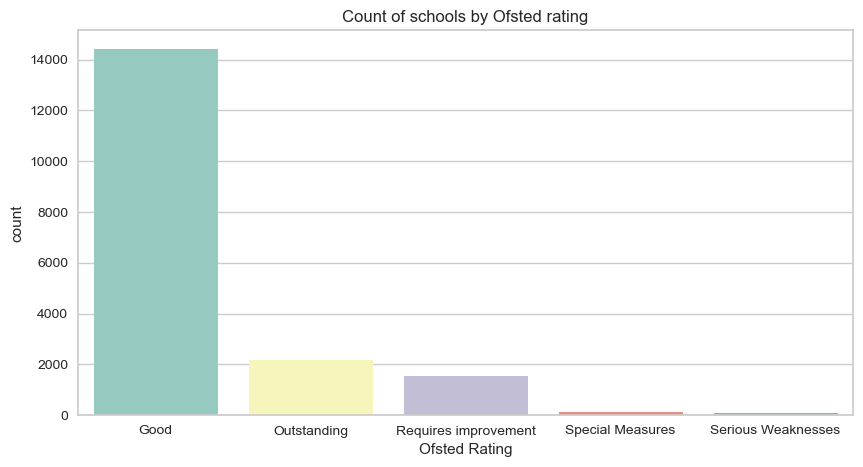

In [522]:
# explore distribution of school Ofsted rating
plt.figure(figsize=(10, 5))
sns.countplot(x='Ofsted Rating', data=schools, palette='Set3')
plt.title('Count of schools by Ofsted rating')
plt.show()

The Serious Weaknesses and Special Measures categories both fall into a 'category of concern' and result in schools being closely monitored (Ofsted, 2023). As there is a low school count for these categories and the implications are similar, these schools will be grouped under the heading 'Category of Concern' to make them easier to analyse. I will also transform them into a new ordinal variable to aid analysis. 

https://www.gov.uk/guidance/inspecting-schools-guide-for-maintained-and-academy-schools#:~:text=When%20we%20judge%20a%20school,or%20to%20require%20special%20measures.

In [523]:
# check values for ofsted rating
np.unique(schools['Ofsted Rating'])

array(['Good', 'Outstanding', 'Requires improvement',
       'Serious Weaknesses', 'Special Measures'], dtype=object)

In [524]:
# create a copy of Ofsted rating column for new Category of Concern label
schools['Ofsted New'] = schools['Ofsted Rating']

In [525]:
# replace labels in new column
schools['Ofsted New'].replace('Serious Weaknesses', 'Category of Concern', 
                              inplace=True)
schools['Ofsted New'].replace('Special Measures', 'Category of Concern', 
                              inplace=True)

In [526]:
# check values for ofsted new
np.unique(schools['Ofsted New'])

array(['Category of Concern', 'Good', 'Outstanding',
       'Requires improvement'], dtype=object)

In [527]:
# create a copy of Ofsted New column to create ordinal variable
schools['Ofsted Score'] = schools['Ofsted New']

In [528]:
# replace strings in new column with numbers so that values can be ordered and to aid visulisation
schools['Ofsted Score'].replace('Category of Concern', 1, inplace=True)
schools['Ofsted Score'].replace('Requires improvement', 2, inplace=True)
schools['Ofsted Score'].replace('Good', 3, inplace=True)
schools['Ofsted Score'].replace('Outstanding', 4, inplace=True)

schools.head()

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score
0,101614,Downe Primary School,Primary,74,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350,161795,10.8,6441.80,510049.0,8.14970,Good,3
1,102028,Forty Hill CofE Primary School,Primary,227,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178,198690,17.2,4958.39,1170602.0,4.98025,Good,3
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660,384721,2.8,4265.00,968304.0,6.27767,Outstanding,4
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989,414229,4.3,4296.65,1315619.0,4.72174,Outstanding,4
4,106270,St Damian's RC Science College,Secondary,837,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017,401424,18.4,6060.34,5422860.0,7.11089,Outstanding,4


In [529]:
# check values for ofsted score
np.unique(schools['Ofsted Score'])

array([1, 2, 3, 4])

#### Urban / Rural Classification

In [530]:
# explore regional classifications
schools.groupby('Region Classification').size()

Region Classification
(England/Wales) Rural hamlet and isolated dwellings                         736
(England/Wales) Rural hamlet and isolated dwellings in a sparse setting      78
(England/Wales) Rural town and fringe                                      1918
(England/Wales) Rural town and fringe in a sparse setting                   104
(England/Wales) Rural village                                              1979
(England/Wales) Rural village in a sparse setting                           144
(England/Wales) Urban city and town                                        7229
(England/Wales) Urban city and town in a sparse setting                      32
(England/Wales) Urban major conurbation                                    5585
(England/Wales) Urban minor conurbation                                     588
dtype: int64

Order of categories 
https://assets.publishing.service.gov.uk/media/610c08e4d3bf7f044024465a/RUCOA_leaflet_Jan2017.pdf

In [531]:
# new column for ordinal variable
schools['RUC Score'] = schools['Region Classification']

In [532]:
# rename categories with numerical labels 
schools['RUC Score'].replace('(England/Wales) Urban major conurbation', 10, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban minor conurbation', 9, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban city and town', 8, inplace=True)
schools['RUC Score'].replace('(England/Wales) Urban city and town in a sparse setting', 7, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural town and fringe', 6, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural village', 5, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural hamlet and isolated dwellings', 4, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural town and fringe in a sparse setting', 3, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural village in a sparse setting', 2, inplace=True)
schools['RUC Score'].replace('(England/Wales) Rural hamlet and isolated dwellings in a sparse setting', 1, inplace=True)
schools.groupby('RUC Score').size()

RUC Score
1       78
2      144
3      104
4      736
5     1979
6     1918
7       32
8     7229
9      588
10    5585
dtype: int64

In [533]:
# save the new dataframe to a csv file
schools.to_csv('schools_df.csv')

# Stage 2: Exploring the data

I am interested in understanding whether there are systematic differences in outcomes for pupils and schools according to their location and the level of funding allocated to them. Now that I have a dataframe containing all of the relevant information, I will explore how these variables of interest are related to each other. 

I am expecting to find:
- a relationship between school location (particularly, how far North a school is in England) and the level of funding it receives per pupil
- a relationship between how much funding a school receives per pupil and school and pupil outcomes (Ofsted rating and absence rate respectively)

### Categorical variable: School Phase

In [534]:
# descriptive statistics for funding per pupil and absence rate grouped by school phase
schools.groupby('Phase')[['Funding per Pupil', 'Total Absence Rate']].describe()

Funding per Pupil                                                \
                        count         mean          std      min        25%   
Phase                                                                         
All-through             125.0  5932.218160   767.477723  4790.00  5369.3400   
Primary               15412.0  5024.145258  1018.670339  4127.11  4383.7250   
Secondary              2856.0  6176.491502   763.143884  4793.00  5638.6375   

                                           Total Absence Rate            \
                  50%        75%       max              count      mean   
Phase                                                                     
All-through  5714.730  6436.2700   9019.31              125.0  8.092358   
Primary      4752.375  5285.1450  22225.33            15412.0  6.263966   
Secondary    5960.405  6484.4025  10662.88             2856.0  8.744837   

                                                                        
                  std      min       25%      50%        75%       max  
Phase                                                                   
All-through  2.005762  4.09522  6.621590  8.05018   9.342090  15.16333  
Primary      1.565215  1.42075  5.310908  6.18777   7.095422  48.37762  
Secondary    2.348396  2.22638  7.249965  8.64382  10.016687  43.40578

The above descriptive statistics are largely in line with what I would expect: 
- the mean funding per pupil is lowest for primary schools and highest for secondary schools, which makes sense as the basic per-pupil funding is about £3,200 in primary schools, rises to £4,500 for pupils in in Key Stage 3 (ages 11–14) and £5,100 for pupils in Key Stage 4 (ages 14–16). 
- The mean absence rate is also highest for secondary schools, which may be partially explained by these students having greater autonomy over travelling to and from school and being able to stay home alone if their parents/carers need to go to work. 

However it is interesting to observe that the maximum values for both variables are considerably higher for primary schools. 
- The funding per pupil for primary schools also has a far higher standard deviation, which suggests there is a broader spread of values. 
- On the other hand, the standard deviation for primary absence rates is low, suggesting the high values for this condition represent anomalous or extreme rates for a small number of schools. 

This can be seen in the scatterplots below - there is a spread of primary schools towards the higher end of funding, but a small number of schools with extreme values for total absence rate. 

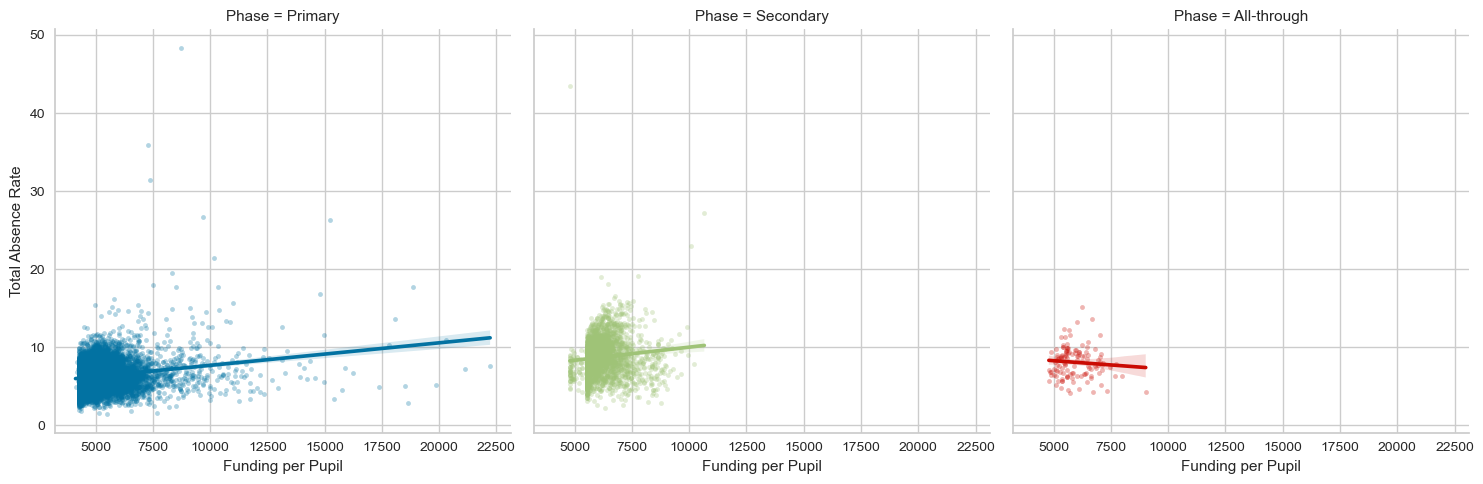

In [535]:
# explore distribution of funding allocation and absence rate by school phase
sns.lmplot(x='Funding per Pupil', y='Total Absence Rate',  hue='Phase',
               col='Phase', data=schools, markers='.', scatter_kws={'alpha':0.3});

In [536]:
# look at the records for schools with absence rates greater than 25%
schools.loc[schools['Total Absence Rate'] > 25]

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score,RUC Score
58,111286,Huxley CofE Primary School,Primary,34,Special Measures,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,351284,361354,8.8,8749.95,385762.0,48.37762,Category of Concern,1,4
595,142276,Hollinsclough Church of England Academy,Primary,30,Good,West Midlands,(England/Wales) Rural hamlet and isolated dwel...,406516,366551,25.9,7374.61,408771.0,31.37413,Good,3,4
3097,112807,Castleton CofE Primary School,Primary,22,Good,East Midlands and the Humber,(England/Wales) Rural village,415075,382971,18.2,9687.62,276746.0,26.75887,Good,3,5
3119,112858,Stoney Middleton CofE (C) Primary School,Primary,11,Good,East Midlands and the Humber,(England/Wales) Rural village,422881,375420,45.5,15236.64,241743.0,26.32637,Good,3,5
9198,137317,Stephenson Studio School,Secondary,79,Requires improvement,East Midlands and the Humber,(England/Wales) Urban city and town,442182,315340,43.0,10662.88,957593.0,27.18099,Requires improvement,2,8
11244,144007,Windsor Park CE Middle School,Secondary,368,Good,West Midlands,(England/Wales) Urban city and town,408526,333745,13.9,4793.00,1955240.0,43.40578,Good,3,8
11738,145772,Crays Hill Primary School,Primary,99,Good,East of England and North-East London,(England/Wales) Urban city and town,571911,192684,87.9,7298.06,869796.0,35.86042,Good,3,8


Looking at the records above, it seems as though the schools with extreme absence rates are very small, with low numbers of pupils on roll, which means that even small levels of absence will have a big impact on the overall rate. 

To double check this, I have run the below code to check the mean number of pupils on roll for Primary and Secondary schools. 

In [537]:
# get the mean number of pupils on roll for Primary and Secondary schools
print(schools.loc[schools['Phase'] == 'Primary', 'Pupils on Roll'].mean(), 
      schools.loc[schools['Phase'] == 'Secondary', 'Pupils on Roll'].mean())

276.18277965221904 1075.312675070028


This confirms that the numbers on roll for the schools above are well below the average, however, these are not the only small schools in the dataframe. Because of this, and as these filtered schools are also predominently located in the Midlands and location is one of the key variables I am investigating, I will leave these records in for now. 

When I come to complete my cluster analysis later, I will use a different approach for outlier detection and removal. 

### Numerical variables: distribution and correlation

In [538]:
# dataframe for continuous variables to check distribution
dist_vars = schools.iloc[:,[3, 7, 8, 9, 10, 12]]

In [539]:
# create a method to draw set of histograms 
def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name + ' Distribution')
    fig.tight_layout() 
    plt.show()

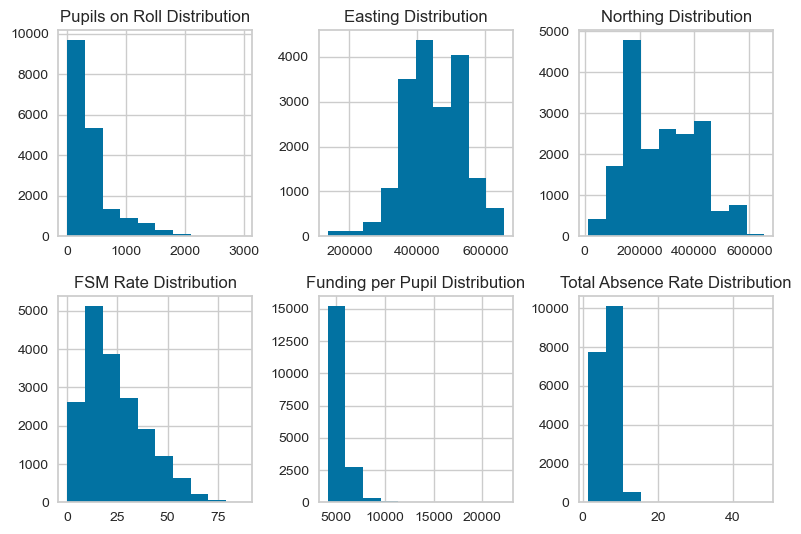

In [540]:
# check distribution of variables
draw_histograms(dist_vars, dist_vars.columns, 2, 3)

In [541]:
# create a dataframe with the numeric variables of interest 
corr_vars = schools.iloc[:,[3, 7, 8, 9, 10, 11, 12, 14, 15]]
corr_vars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18393 entries, 0 to 18397
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pupils on Roll      18393 non-null  int64  
 1   Easting             18393 non-null  int64  
 2   Northing            18393 non-null  int64  
 3   FSM Rate            18393 non-null  float64
 4   Funding per Pupil   18393 non-null  float64
 5   Total Funding       18393 non-null  float64
 6   Total Absence Rate  18393 non-null  float64
 7   Ofsted Score        18393 non-null  int64  
 8   RUC Score           18393 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.4 MB


In [542]:
# descriptive statistics 
corr_vars.describe()

,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted Score,RUC Score
count,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,1.839300e+04,18393.000000,18393.000000,18393.000000
mean,407.943076,449519.861958,283098.282281,23.798179,5209.248829,2.225124e+06,6.661613,3.008047,7.841190
std,370.936608,85772.681426,128030.985179,14.865533,1068.371258,2.147617e+06,1.938132,0.503403,1.969774
min,5.000000,136274.000000,12574.000000,0.000000,4127.110000,2.147650e+05,1.420750,1.000000,1.000000
25%,188.000000,389664.000000,177567.000000,12.100000,4434.150000,9.572330e+05,5.448700,3.000000,6.000000
50%,278.000000,443490.000000,275118.000000,20.300000,4935.380000,1.433495e+06,6.402260,3.000000,8.000000
75%,457.000000,519644.000000,392624.000000,33.000000,5628.300000,2.383614e+06,7.570130,3.000000,10.000000
max,2990.000000,654588.000000,654722.000000,87.900000,22225.330000,1.770485e+07,48.377620,4.000000,10.000000


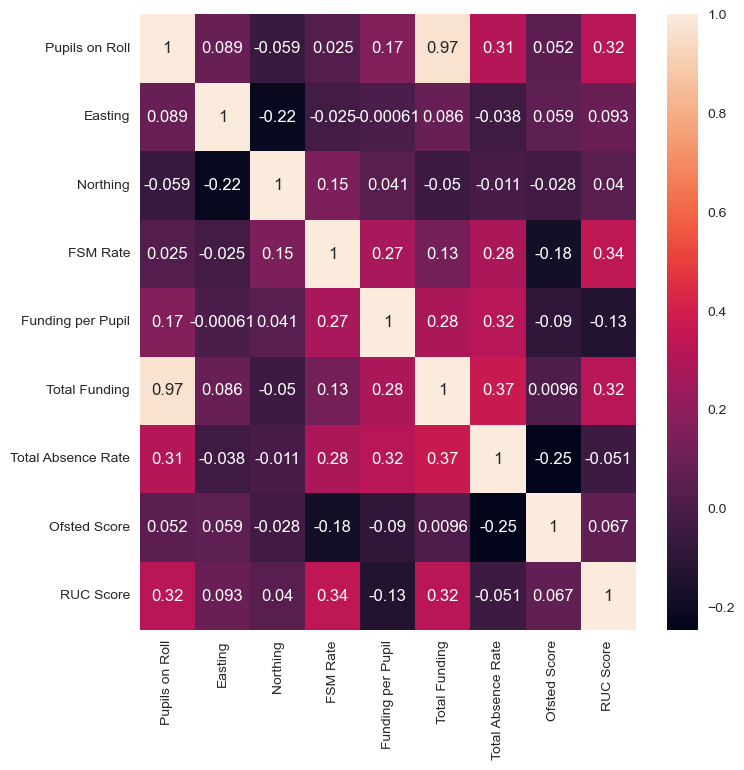

In [543]:
# plot correlation matrix as heatmap to view results more clearly
plt.figure(figsize=(8,8))    # set figure size
sns.heatmap(corr_vars.corr(), annot = True);  # annot = True annotates the cells with the correlation value

The above correlation matrix shows that the total funding allocated per school is very strongly correlated with the number of pupils on roll, which is exactly what I would expect, as this is the main factor that contributes to the calculation of school funding.  

#### School funding, Ofsted ratings and absences
I was expecting to find a relationship between how much funding a school receives per pupil and school and pupil outcomes (Ofsted rating and absence rate respectively). 

Whilst there does not appear to be any relationship between the funding a school receives and its Ofsted rating, there is a positive correlation between the funding a school receives (both overall and calculated as a per pupil rate) and the overall absence rate. This may be due to the funding formula that means schools receive additional funding for pupils with characteristics that make it more difficult to engage with school. Indeed, the matrix shows a small positive correlation between the proportion of pupils eligible for free school meals and the overall school absence rate. This finding is in line with research that has shown a more deprived background can act as a barrier to engagement with education (REFERENCE). 

The correlation between school funding and overall absence rate could suggest that funding is being prioritised towards the right schools, on the basis of these additional challenges, but it may also suggest that this strategy is having limited impact in terms of overcoming barriers to engagement. 

It is also interesting to note that there is a small negative correlation between the two output variables - Ofsted rating and school absences - which means that higher performing schools in this data set tend to have slightly lower absence rates. This finding does make sense, and may have influenced the lack of relationship between school funding and ofsted rating observed here. 


#### School location
I was expecting to find a relationship between school location (particularly, how far North a school is in England) and the level of funding it receives per pupil. 

There is a positive correlation between Rural/Urban Classification Score and the total funding, FSM rate and pupils on roll. This indicates that schools in more densly populated areas, have more pupils on roll and a higher proportion who are eligible for FSM. Both of these factors are directly related to how much funding a school receives. 

According to this data, there seems to be no relationship between the Northing coordinate of the school and any of the other variables in the matrix. However, this may just mean that the relationship between these variables is not linear. I will investigate this further by grouping the schools into deciles based on their Northing coordinates and plotting the means for Funding per Pupil. 

### Exploring a non-linear relationship between Northing coordinate and allocated funding

In [544]:
# create a new dataframe with variables of interest
n_deciles = schools[['Northing', 'Funding per Pupil']]
n_deciles

,Northing,Funding per Pupil
0,161795,6441.80
1,198690,4958.39
2,384721,4265.00
3,414229,4296.65
4,401424,6060.34
...,...,...
18393,340452,4729.73
18394,349475,4414.42
18395,383341,4265.00
18396,336870,4265.00


In [545]:
# allocate records into deciles based on Norting coordinate
n_deciles['Decile'] = pd.qcut(n_deciles['Northing'], 10, labels=False)
n_deciles

,Northing,Funding per Pupil,Decile
0,161795,6441.80,1
1,198690,4958.39,3
2,384721,4265.00,7
3,414229,4296.65,8
4,401424,6060.34,7
...,...,...,...
18393,340452,4729.73,6
18394,349475,4414.42,6
18395,383341,4265.00,7
18396,336870,4265.00,6


In [546]:
# find the decile means
northing_deciles = n_deciles.groupby('Decile').mean()
northing_deciles

,Northing,Funding per Pupil
Decile,,
0,95147.052717,5109.840647
1,154932.985318,4982.958831
2,177580.508972,5657.963883
3,196705.221316,5198.836797
4,244299.161413,5071.683402
5,292637.572594,5112.161561
6,341542.083741,5202.390239
7,392571.508972,5157.788135
8,422151.611202,5064.979005


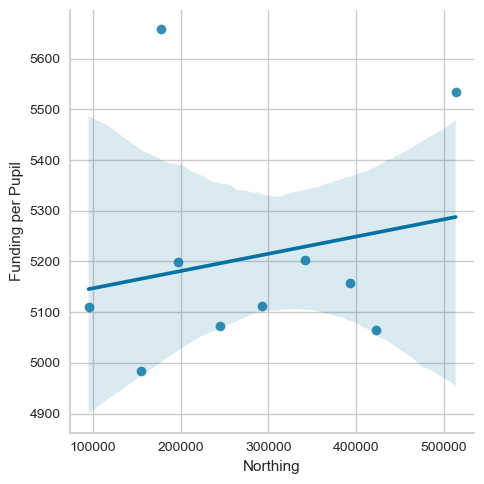

In [547]:
# plot a regression plot
g = sns.lmplot(x='Northing', y='Funding per Pupil', data=northing_deciles)

From the above plot it appears there are two deciles with very high average funding allocations - the 3rd and the 10th deciles. 

Interpretation: 
- The peak in the 3rd decile represents the high levels of funding allocated to London schools, taking into consideration the higher costs for buildings, utilities and staff wages, as well as high proportions of children eligible for FSM or with English as an additional language. 
- The peak in the 10th decile represents the relatively high levels of funding allocated to schools in the North of England that are very small and in very remote locations. This 'sparcity funding' recognises the limited opportunities these schools have to grow or make efficiency savings. 

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1003463/Schools_NFF_changes_to_sparsity_factor_2022-23_-_consultation_response_-_July_2021.pdf 

# Stage 3: Unsupervised machine learning

The next step is to use unsupervised machine learning techniques to see whether this can identify any meaningful or useful patterns in the characteristics of these schools.

### Data preparation steps:

- I will exclude Total Funding as it was highly correlated with Pupils on Roll (0.97) and there is a more appropriate measure of funding in the form of Funding per Pupil.
- I will use sklearn's preprocessing OrdinalEncoder and OneHotEncoder to transform the categorical variables and ordinal variable (Ofsted rating) into numeric variables
- I will use another sklearn transformer, PowerTransformer, on the continuous variables to increase the normality of the distribution
- KMeans clustering is very sensitive to anomolies and so I will use ECOD (empirical cumulative distribution functions for outlier detection) to identify any outliers for removal. 

## Data Transformation

In [449]:
# transformer to covert categorical variables 
cat_transformer_onehot = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', 
                                                                            sparse=False))])

# set order of values for ordinal variable
cat_transformer_ordinal = Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['Outstanding', 'Good', 
                                                                       'Requires improvement',
                                                                       'Serious Weaknesses',
                                                                       'Special Measures']]))])

# transformer to move towards normal distribution of numerical variables
num = Pipeline(steps=[('encoder', PowerTransformer())])      

In [450]:
# classify columns for transformation
preprocessor  = ColumnTransformer(transformers = [
    ('cat_onehot', cat_transformer_onehot, 
     ['Phase']), 
    ('cat_ordinal', cat_transformer_ordinal,
     ['Ofsted Rating']),
    ('num', num,
     ['Pupils on Roll', 'RUC Score', 'Easting', 'Northing','FSM Rate', 
      'Funding per Pupil', 'Total Absence Rate'])
])

In [451]:
# transform the data
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
pipe_fit = pipeline.fit(schools)

schools_transformed = pd.DataFrame(pipe_fit.transform(schools), columns = pipe_fit.get_feature_names_out().tolist())
schools_transformed

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__RUC Score,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
0,0.0,1.0,0.0,1.0,-1.611473,-1.727800,1.108740,-0.931328,-0.867503,1.399270e-12,0.882525
1,0.0,1.0,0.0,1.0,-0.311165,-1.727800,0.994240,-0.584974,-0.271098,2.164935e-14,-0.931616
2,0.0,1.0,0.0,0.0,-0.353744,-1.727800,-1.431537,0.827640,-2.087432,-1.427580e-12,-0.074673
3,0.0,1.0,0.0,0.0,-0.078138,-1.727800,-0.862764,1.019092,-1.773795,-1.340095e-12,-1.129193
4,0.0,0.0,1.0,0.0,1.278216,-1.727800,-0.660648,0.936814,-0.176025,1.167400e-12,0.384096
...,...,...,...,...,...,...,...,...,...,...,...
18388,0.0,1.0,0.0,1.0,0.161785,0.547165,-0.077423,0.527163,1.187236,-3.642087e-13,0.048642
18389,0.0,1.0,0.0,1.0,-0.426229,0.547165,-0.128365,0.589810,0.272970,-1.036227e-12,-0.618662
18390,0.0,1.0,0.0,1.0,0.165359,0.547165,-0.090206,0.818523,-0.320242,-1.427580e-12,-0.420300
18391,0.0,1.0,0.0,1.0,0.454277,0.547165,0.083688,0.502080,-1.792665,-1.427580e-12,-0.809277


In [452]:
schools_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cat_onehot__Phase_All-through  18393 non-null  float64
 1   cat_onehot__Phase_Primary      18393 non-null  float64
 2   cat_onehot__Phase_Secondary    18393 non-null  float64
 3   cat_ordinal__Ofsted Rating     18393 non-null  float64
 4   num__Pupils on Roll            18393 non-null  float64
 5   num__RUC Score                 18393 non-null  float64
 6   num__Easting                   18393 non-null  float64
 7   num__Northing                  18393 non-null  float64
 8   num__FSM Rate                  18393 non-null  float64
 9   num__Funding per Pupil         18393 non-null  float64
 10  num__Total Absence Rate        18393 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


In [453]:
# create a df containing the transformed continuous variables to compare to previous distributions
dist_vars_transformed = schools_transformed.iloc[:,[4, 6, 7, 8, 9, 10]]

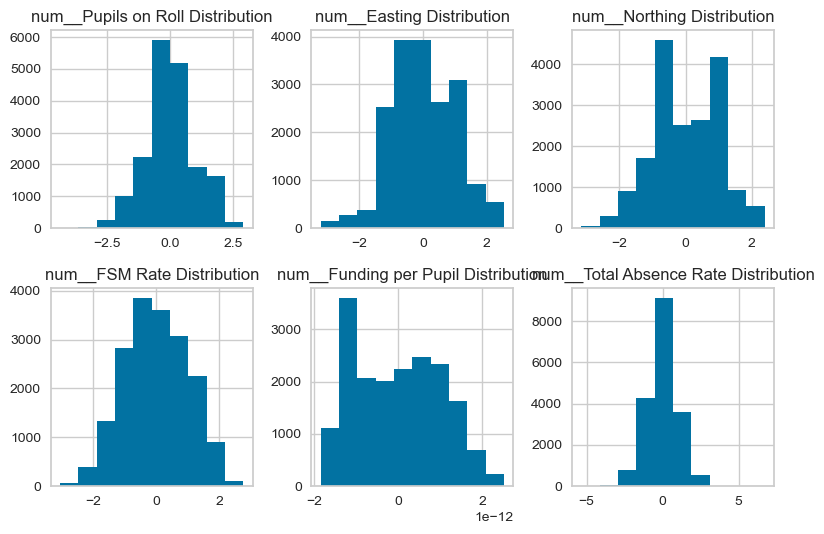

In [454]:
# plot distribution of transformed continuous varibles to confirm improved normality
draw_histograms(dist_vars_transformed, dist_vars_transformed.columns, 2, 3)

### Check for and remove anomolies

In [455]:
# unsupervised outlier detection
clf = ECOD()
clf.fit(schools_transformed)
outliers = clf.predict(schools_transformed)

schools_transformed['Outliers'] = outliers
schools_transformed.head()

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__RUC Score,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate,Outliers
0,0.0,1.0,0.0,1.0,-1.611473,-1.7278,1.108740,-0.931328,-0.867503,1.399270e-12,0.882525,0
1,0.0,1.0,0.0,1.0,-0.311165,-1.7278,0.994240,-0.584974,-0.271098,2.164935e-14,-0.931616,0
2,0.0,1.0,0.0,0.0,-0.353744,-1.7278,-1.431537,0.827640,-2.087432,-1.427580e-12,-0.074673,1
3,0.0,1.0,0.0,0.0,-0.078138,-1.7278,-0.862764,1.019092,-1.773795,-1.340095e-12,-1.129193,0
4,0.0,0.0,1.0,0.0,1.278216,-1.7278,-0.660648,0.936814,-0.176025,1.167400e-12,0.384096,0


In [456]:
# count outliers detected
schools_transformed.groupby('Outliers').size()

Outliers
0    16553
1     1840
dtype: int64

In [457]:
# create new dataframe with outliers removed
df_clean = schools_transformed.copy()
df_clean = df_clean[df_clean['Outliers'] == 0]
df_clean = df_clean.drop(['Outliers'], axis = 1)

# check correct number of records remain, and column removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16553 entries, 0 to 18392
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cat_onehot__Phase_All-through  16553 non-null  float64
 1   cat_onehot__Phase_Primary      16553 non-null  float64
 2   cat_onehot__Phase_Secondary    16553 non-null  float64
 3   cat_ordinal__Ofsted Rating     16553 non-null  float64
 4   num__Pupils on Roll            16553 non-null  float64
 5   num__RUC Score                 16553 non-null  float64
 6   num__Easting                   16553 non-null  float64
 7   num__Northing                  16553 non-null  float64
 8   num__FSM Rate                  16553 non-null  float64
 9   num__Funding per Pupil         16553 non-null  float64
 10  num__Total Absence Rate        16553 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


### Determine number of clusters to use

In [458]:
# iterate through the model using increments of k and record the sum of the squared error (SSE) for each
kmeans_kwargs = {'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 42}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_clean)
    sse.append(kmeans.inertia_)

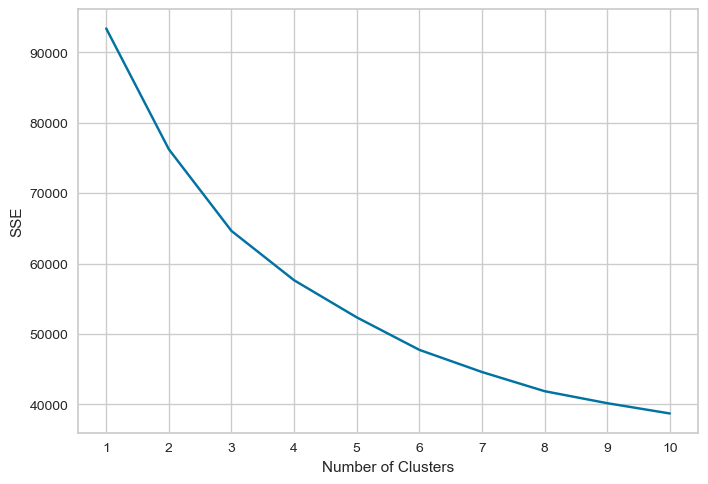

In [459]:
# plot results to look for 'elbow'
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

There is not an easily identifiable 'elbow' in the plot above, however the line seems to flatten off after 3 clusters, suggesting this could be the optimal. 

## Clustering approach 1: Raw data

In [460]:
# create a new instance of k-means class with 3 clusters
estimator = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42)
estimator

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [461]:
# fit the data to the estimator
X = df_clean
estimator.fit(X)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [462]:
# get cluster labels assigned to each data point
estimator.labels_

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

In [463]:
# check all datapoints have been assigned to a cluster
len(estimator.labels_) == len(X)

True

In [464]:
# final cluster centroid locations (4 clusters x 11 variables)
estimator.cluster_centers_

array([[ 1.96155355e-04,  9.88819145e-01,  1.09846999e-02,
         9.72930561e-01, -7.48700836e-01, -9.60971567e-01,
        -1.63139179e-01, -1.07743365e-01, -7.03004301e-01,
        -2.97327951e-13, -3.10452657e-01],
       [ 1.16414435e-03,  8.52985199e-01,  1.45850657e-01,
         1.01746217e+00,  2.03861079e-01,  5.47908281e-01,
        -5.44958518e-01,  7.72113733e-01,  5.46794241e-01,
        -6.09410798e-14,  8.47961299e-02],
       [ 1.65380375e-03,  8.28004410e-01,  1.70341786e-01,
         9.32194046e-01,  3.83733458e-01,  4.12648541e-01,
         8.71646333e-01, -7.19626579e-01,  4.10421350e-02,
        -6.08907143e-14, -5.44367356e-02]])

In [465]:
# the number of iterations required to converge
estimator.n_iter_

17

In [466]:
# save cluster allocation output
k3_raw = pd.Series(estimator.labels_, index=X.index)
k3_raw.head()

0    0
1    0
3    0
4    1
5    0
dtype: int32

## Clustering approach 2: Re-scaled data

In [467]:
# re-scale the variables of interest so they are standardised to values between 0 and 1
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df_clean.values), 
                      columns=df_clean.columns, index=df_clean.index)

scaled_df.describe()

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__RUC Score,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
count,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000
mean,0.001027,0.886607,0.112366,0.243929,0.525241,0.658945,0.546363,0.525592,0.555283,0.369619,0.592095
std,0.032031,0.317083,0.315826,0.118267,0.154482,0.275728,0.171098,0.190271,0.176697,0.246028,0.107008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.250000,0.439058,0.350869,0.414757,0.370947,0.424986,0.127530,0.527029
50%,0.000000,1.000000,0.000000,0.250000,0.509713,0.631312,0.525942,0.534615,0.547361,0.356881,0.595800
75%,0.000000,1.000000,0.000000,0.250000,0.614836,1.000000,0.686492,0.697112,0.687311,0.583823,0.661877
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [468]:
# fit the data to the estimator
X = scaled_df
estimator.fit(X)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [469]:
# save cluster allocation output
k3_scaled = pd.Series(estimator.labels_, index=X.index)
k3_scaled.head()

0    0
1    0
3    0
4    2
5    0
dtype: int32

## Clustering approach 3: Principle Component Analysis (PCA)

For the visualisations, PCA can be used to reduce dimensionality. Before I apply PCA the data needs to be centred but not scaled. 

In [470]:
centred_df = df_clean.apply(lambda x: x-x.mean())
centred_df

,cat_onehot__Phase_All-through,cat_onehot__Phase_Primary,cat_onehot__Phase_Secondary,cat_ordinal__Ofsted Rating,num__Pupils on Roll,num__RUC Score,num__Easting,num__Northing,num__FSM Rate,num__Funding per Pupil,num__Total Absence Rate
0,-0.001027,0.113393,-0.112366,0.024286,-1.581099,-1.766535,1.070379,-0.942035,-0.863112,1.532997e-12,0.965232
1,-0.001027,0.113393,-0.112366,0.024286,-0.280790,-1.766535,0.955880,-0.595681,-0.266707,1.553764e-13,-0.848909
3,-0.001027,0.113393,-0.112366,-0.975714,-0.047764,-1.766535,-0.901124,1.008385,-1.769404,-1.206368e-12,-1.046485
4,-0.001027,-0.886607,0.887634,-0.975714,1.308590,-1.766535,-0.699008,0.926106,-0.171634,1.301127e-12,0.466803
5,-0.001027,0.113393,-0.112366,0.024286,-1.047482,-1.766535,-0.633455,1.151763,-1.262756,6.861185e-13,0.937558
...,...,...,...,...,...,...,...,...,...,...,...
18388,-0.001027,0.113393,-0.112366,0.024286,0.192159,0.508430,-0.115783,0.516455,1.191627,-2.304816e-13,0.131350
18389,-0.001027,0.113393,-0.112366,0.024286,-0.395855,0.508430,-0.166726,0.579103,0.277362,-9.024996e-13,-0.535954
18390,-0.001027,0.113393,-0.112366,0.024286,0.195733,0.508430,-0.128566,0.807816,-0.315850,-1.293853e-12,-0.337592
18391,-0.001027,0.113393,-0.112366,0.024286,0.484651,0.508430,0.045328,0.491372,-1.788274,-1.293853e-12,-0.726570


In [471]:
# reduce the 11 features down to the 2 with the most variance (principle component analysis)
pca_estimator = PCA(n_components=2)
pca_estimator

PCA(n_components=2)

In [472]:
# fit the data to the model and transform in a single step
X = centred_df
components = pca_estimator.fit_transform(X)
components

array([[ 2.27379278, -0.71773417],
       [ 1.7558042 , -0.65104043],
       [ 2.1348279 ,  1.32157012],
       ...,
       [-0.27339392,  0.48096017],
       [ 0.61400253, -0.08699463],
       [-1.59788821,  0.83287518]])

In [473]:
# save as dataframe
components = pd.DataFrame(components, index=df_clean.index, columns = ['C1', 'C2'])
components.head()

,C1,C2
0,2.273793,-0.717734
1,1.755804,-0.651040
3,2.134828,1.321570
4,0.103587,0.674715
5,1.739018,1.546019


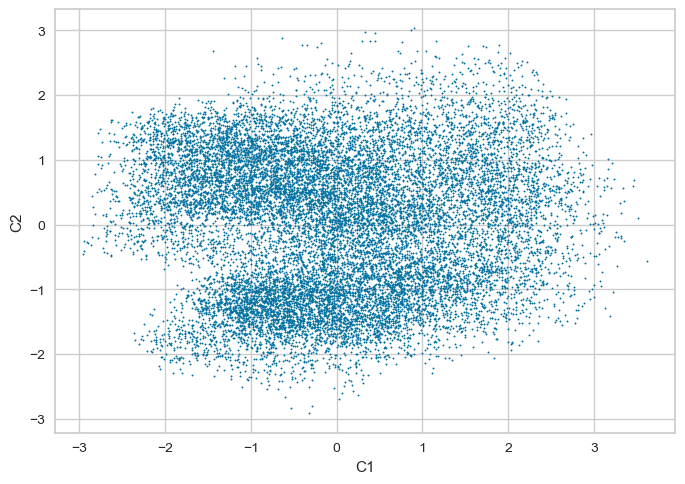

In [474]:
components.plot.scatter('C1', 'C2', s=1);

In [475]:
# fit to model
estimator.fit(components)
k3_pca = pd.Series(estimator.labels_, index=components.index)
k3_pca.head()

0    1
1    1
3    1
4    0
5    1
dtype: int32

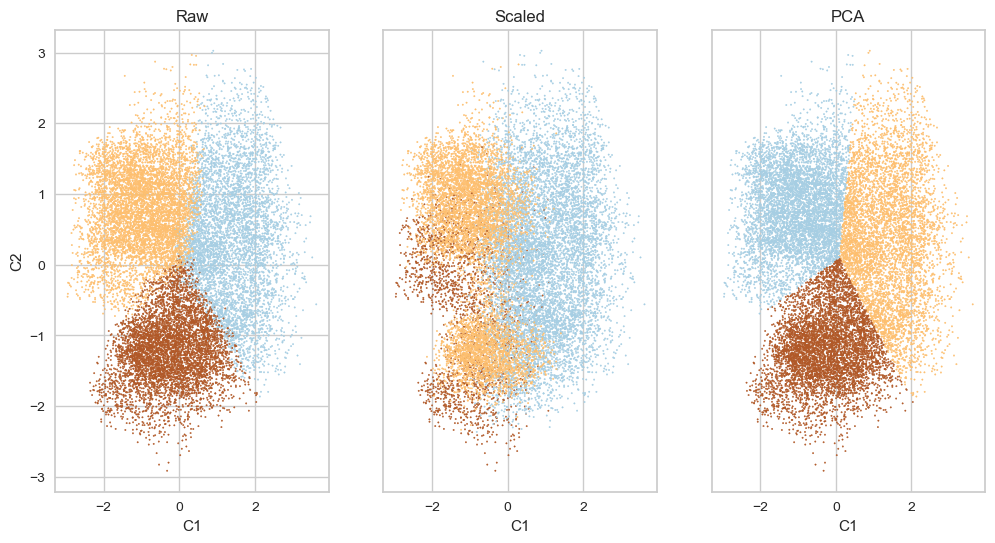

In [476]:
f, axs = plt.subplots(1, 3, figsize=(12, 6))

ax = axs[0]
components.assign(labels=k3_raw).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title('Raw')


ax = axs[1]
components.assign(labels=k3_scaled).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title('Scaled')
ax.yaxis.set_visible(False)


ax = axs[2]
components.assign(labels=k3_pca).plot.scatter('C1', 'C2', c='labels', s=1,
                        cmap='Paired', colorbar=False, ax=ax)
ax.set_title("PCA")
ax.yaxis.set_visible(False)

plt.show()

In [477]:
# Compute the Calinski and Harabasz score: sum of between-cluster dispersion and of within-cluster dispersion
chs_raw = calinski_harabasz_score(df_clean, k3_raw)
chs_scaled = calinski_harabasz_score(df_clean, k3_scaled)
chs_PCA = calinski_harabasz_score(df_clean, k3_pca)

pd.Series({'Raw:': chs_raw, 'Scaled': chs_scaled, 'PCA': chs_PCA})

Raw:      3679.241244
Scaled    2852.801733
PCA       3653.708589
dtype: float64

The Calinski and Harabasz scores above suggest that the clustering on the raw data is superior, in that it maximises the between group dispersion and minimises the within group dispersion.  

## Add cluster labels to schools dataframe

In [478]:
# create df for the cluster allocations with matching index
k3 = k3_raw.to_frame()
k3

,0
0,0
1,0
3,0
4,1
5,0
...,...
18388,1
18389,1
18390,1
18391,0


In [479]:
# create copy of schools df
schools_clustered = schools
schools_clustered

,URN,School Name,Phase,Pupils on Roll,Ofsted Rating,RSC Region,Region Classification,Easting,Northing,FSM Rate,Funding per Pupil,Total Funding,Total Absence Rate,Ofsted New,Ofsted Score,RUC Score
0,101614,Downe Primary School,Primary,74,Good,South-East England and South London,(England/Wales) Rural hamlet and isolated dwel...,543350,161795,10.8,6441.80,510049.0,8.14970,Good,3,4
1,102028,Forty Hill CofE Primary School,Primary,227,Good,North-West London and South-Central England,(England/Wales) Rural hamlet and isolated dwel...,534178,198690,17.2,4958.39,1170602.0,4.98025,Good,3,4
2,105078,Thurstaston Dawpool CofE Primary School,Primary,219,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,324660,384721,2.8,4265.00,968304.0,6.27767,Outstanding,4,4
3,105344,"Holly Mount Roman Catholic Primary School, Bury",Primary,276,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,376989,414229,4.3,4296.65,1315619.0,4.72174,Outstanding,4,4
4,106270,St Damian's RC Science College,Secondary,837,Outstanding,Lancashire and West Yorkshire,(England/Wales) Rural hamlet and isolated dwel...,395017,401424,18.4,6060.34,5422860.0,7.11089,Outstanding,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,148017,Ladywood Primary School,Primary,337,Good,East Midlands and the Humber,(England/Wales) Urban minor conurbation,445635,340452,42.0,4729.73,1714442.0,6.49110,Good,3,9
18394,148018,Waingroves Primary School,Primary,206,Good,East Midlands and the Humber,(England/Wales) Urban minor conurbation,441290,349475,24.8,4414.42,1031910.0,5.41906,Good,3,9
18395,148100,Brook House Junior,Primary,338,Good,East Midlands and the Humber,(England/Wales) Urban minor conurbation,444546,383341,16.6,4265.00,1594303.0,5.71727,Good,3,9
18396,148168,Abbey Road Primary School,Primary,429,Good,East Midlands and the Humber,(England/Wales) Urban minor conurbation,459288,336870,4.2,4265.00,1968849.0,5.14736,Good,3,9


In [480]:
# join dataframes to create schools df with cluster classifications
schools_clustered = schools_clustered.join(k3, lsuffix='_caller', rsuffix='_other')
schools_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18393 entries, 0 to 18397
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URN                    18393 non-null  int64  
 1   School Name            18393 non-null  object 
 2   Phase                  18393 non-null  object 
 3   Pupils on Roll         18393 non-null  int64  
 4   Ofsted Rating          18393 non-null  object 
 5   RSC Region             18393 non-null  object 
 6   Region Classification  18393 non-null  object 
 7   Easting                18393 non-null  int64  
 8   Northing               18393 non-null  int64  
 9   FSM Rate               18393 non-null  float64
 10  Funding per Pupil      18393 non-null  float64
 11  Total Funding          18393 non-null  float64
 12  Total Absence Rate     18393 non-null  float64
 13  Ofsted New             18393 non-null  object 
 14  Ofsted Score           18393 non-null  int64  
 15  RUC Sco

In [481]:
# rename 'cluster' column from 0
schools_clustered.columns = ['Cluster' if x==0 else x for x in schools_clustered.columns]

## Examine school cluster characteristics

In [482]:
# compare cluster means
schools_clustered.groupby('Cluster')[['Pupils on Roll',
                                      'Easting',
                                      'Northing',
                                      'FSM Rate',
                                      'Funding per Pupil', 
                                      'Total Absence Rate',
                                      'Ofsted Score', 
                                      'RUC Score'
                                     ]].mean()

,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Total Absence Rate,Ofsted Score,RUC Score
Cluster,,,,,,,,
0.0,243.253239,441982.781704,272010.146839,17.641441,5176.254784,6.528100,2.981154,5.980958
1.0,451.746050,424890.258773,343169.817728,28.582022,5061.900675,6.679721,2.999335,8.925994
2.0,491.658151,491728.368131,224170.955339,24.570759,5177.785113,6.607891,3.046499,8.690682


The largest variations that characterise these three clusters are in number of pupils on roll, FSM rate and RUC score. 

Cluster '0' contains the smallest and most rural schools, with relatively low proportions of pupils eligible for FSM. 

Interestingly, whilst cluster '1' has the highest rate of school absence and of pupils eligible for FSM, it doesn't have the highest mean funding allocation per pupil. Instead, cluster '2' has the highest funding per pupil. 

To investigate this further, I will plot the location of each school using the 'Easting' and 'Northing' coordinates, coloured by cluster allocation. 

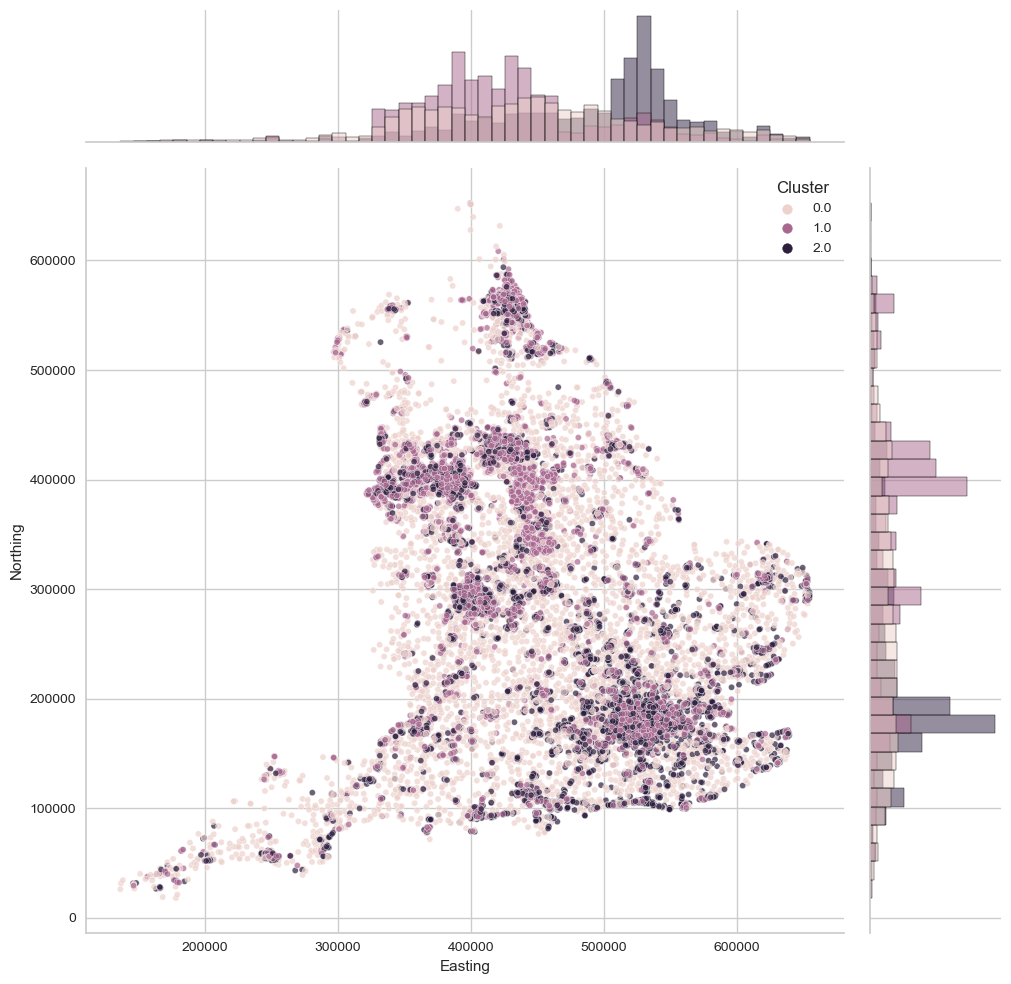

In [486]:
g = sns.JointGrid(data=schools_clustered, x='Easting', y='Northing', hue='Cluster', height=10)
g.plot_joint(sns.scatterplot, s=20, alpha=0.7)
g.plot_marginals(sns.histplot);

The scatterplot and axis histograms show that the density of schools is highest around the main cities in England - London, Birmingham, Leeds, Newcastle, Manchester and Liverpool. Outside of these areas are predominantly cluster '0' schools, which are the smaller, more rural schools. 

This plot also shows that the majority of cluster '2' schools are located in the South East of England and Greater London. This cluster has the highest mean allocation of funding per pupil. 

There is a concentration of cluster '1' in inner London, as well as around the Northern cities. This cluster has the highest average rates of school absence and pupils eligible for FSM. 

This plot appears to lend some support to the statements made in the Child of the North paper mentioned in the introduction, that funding doesnt sufficiently follow need in the urban north of England. 

# Stage 4: Supervised machine learning

The final step is to see whether I can use supervised machine learning to train a model to predict the outcome I am interested in from this input data. I have chosen to focus on school absence rates as I have seen from my earlier analysis that it has stronger relationships with the input variables than Ofsted rating. 

If I can train a model to reliably predict observed school absence rates, then it would have potential application in testing out the impact of any proposed policy changes that may impact school absenses in the future. For example, how could school attendance be impacted if the funding allocation to schools was to be reduced. 

### Regression Tree: Predicting School Absence Rates

In [591]:
schools_reg = schools
# remove all-through schools as there are relatively few of them and primary / secondary can be treated as ordinal
schools_reg = schools_reg.loc[schools_reg['Phase'] != 'All-through']
schools_reg['Phase'].unique()

array(['Primary', 'Secondary'], dtype=object)

In [592]:
schools_reg['Phase'].replace('Primary', 1, inplace=True)
schools_reg['Phase'].replace('Secondary', 2, inplace=True)
schools_reg['Phase'].unique()

array([1, 2])

In [593]:
# create dataframes containing the regression input and output variables
X = schools_reg.drop(['URN', 'School Name', 'Ofsted Rating', 'RSC Region', 'Region Classification', 
                      'Total Funding', 'Total Absence Rate', 'Ofsted New'], axis=1)
y = schools_reg['Total Absence Rate']
X

,Phase,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Ofsted Score,RUC Score
0,1,74,543350,161795,10.8,6441.80,3,4
1,1,227,534178,198690,17.2,4958.39,3,4
2,1,219,324660,384721,2.8,4265.00,4,4
3,1,276,376989,414229,4.3,4296.65,4,4
4,2,837,395017,401424,18.4,6060.34,4,4
...,...,...,...,...,...,...,...,...
18393,1,337,445635,340452,42.0,4729.73,3,9
18394,1,206,441290,349475,24.8,4414.42,3,9
18395,1,338,444546,383341,16.6,4265.00,3,9
18396,1,429,459288,336870,4.2,4265.00,3,9


In [594]:
# split data into train and test groups (30% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [595]:
# check the new X and y train dfs are the same length
len(X_train) == len(y_train)

True

In [596]:
# create regression tree model and train on train data
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

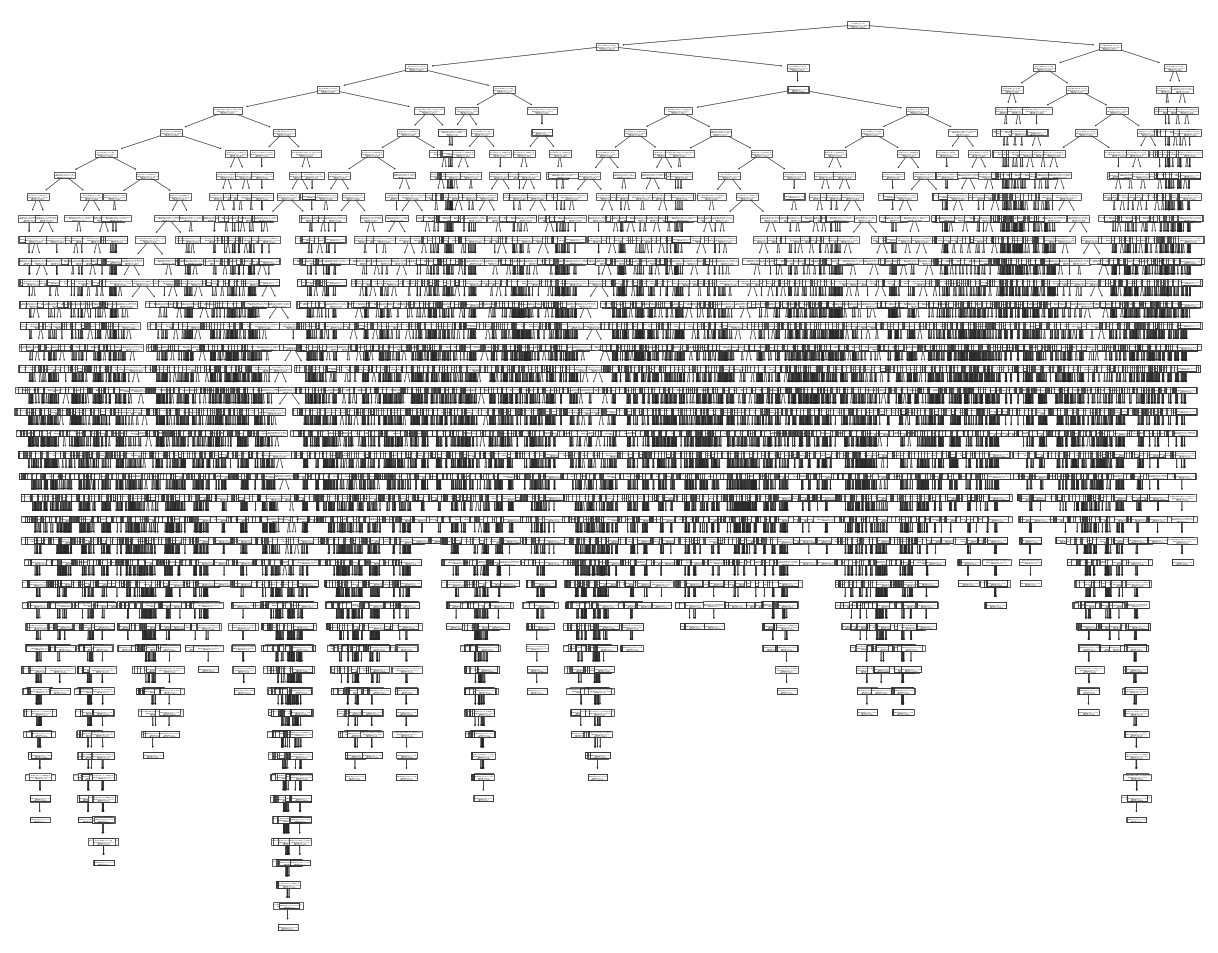

In [556]:

plt.figure(figsize=(10,8), dpi=150)
plot_tree(model, feature_names=['Phase', 'Pupils on Roll', 'Easting', 'Northing', 'FSM Rate',
       'Funding per Pupil', 'Ofsted Score', 'RUC Score']);

In [597]:
# use the trained model to make predictions for absence rates in X_test
predictions = model.predict(X_test)
predictions

array([7.56736, 5.33327, 7.10157, ..., 5.8649 , 5.79057, 7.03321])

In [598]:
# create a df of predicted values
predictions_df = pd.DataFrame(predictions, columns=['Predicted Absence Rate'])
predictions_df

,Predicted Absence Rate
0,7.56736
1,5.33327
2,7.10157
3,4.00381
4,6.36947
...,...
5476,5.49674
5477,6.35419
5478,5.86490
5479,5.79057


In [599]:
# reset index for y_test and then merge with predicted values
actuals = y_test.reset_index()
plot_df = pd.merge(predictions_df, actuals['Total Absence Rate'], left_index=True, right_index=True, how='inner')
plot_df

,Predicted Absence Rate,Total Absence Rate
0,7.56736,5.18567
1,5.33327,6.86476
2,7.10157,6.24884
3,4.00381,4.18285
4,6.36947,7.81352
...,...,...
5476,5.49674,8.49181
5477,6.35419,6.96572
5478,5.86490,5.94317
5479,5.79057,7.17155


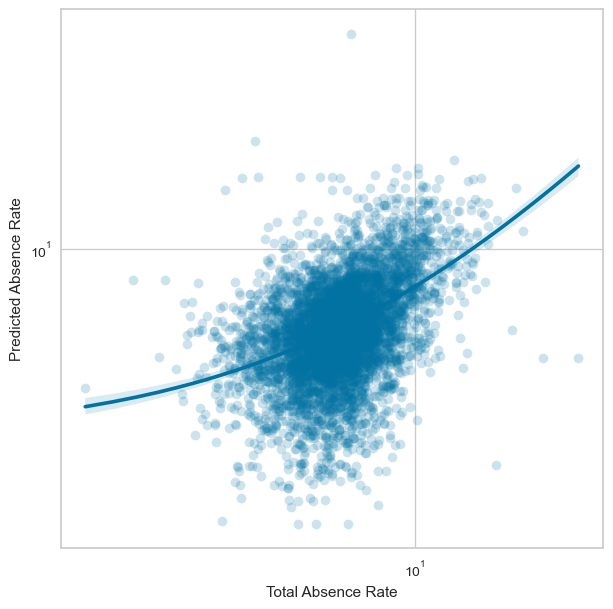

In [600]:
# plot actual vs predicted values
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale='log', yscale='log')
sns.regplot(x='Total Absence Rate', y='Predicted Absence Rate', data=plot_df, ax=ax, scatter_kws={'alpha':0.2});

The visulalisation suggests the model is able to somewhat predict the actual school absence rates based on the inputs it has been trained on, to the extent that these values are positively correlated (confirmed below). 

In [601]:
np.corrcoef(plot_df['Total Absence Rate'], plot_df['Predicted Absence Rate'])[0,1]

0.44620237035187643

However, I can formally assess the performance of the model using the mean square error (MSE) and root (R)MSE which measure the average difference between the actual and predicted values from the model, and are useful for comparing the performance of different models.

In [602]:
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('MSE:',mse,'RMSE:',rmse)

MSE: 3.807246822962306 RMSE: 1.951216754479703


### Transformed Data

We have seen that several of our input variables are positively skewed so I will use a log transformation to see if this improves the model. 

In [605]:
# check values before transforming
X.describe()

,Phase,Pupils on Roll,Easting,Northing,FSM Rate,Funding per Pupil,Ofsted Score,RUC Score
count,18268.000000,18268.000000,18268.000000,18268.000000,18268.000000,18268.000000,18268.000000,18268.000000
mean,1.156339,401.117911,449371.478377,283265.511824,23.756640,5204.301864,3.008430,7.835231
std,0.363186,360.333766,85834.604631,128074.838447,14.858715,1068.470039,0.502618,1.970745
min,1.000000,5.000000,136274.000000,12574.000000,0.000000,4127.110000,1.000000,1.000000
25%,1.000000,187.000000,389509.500000,177543.250000,12.100000,4431.565000,3.000000,6.000000
50%,1.000000,275.000000,443429.500000,275634.500000,20.300000,4928.335000,3.000000,8.000000
75%,1.000000,454.000000,519498.750000,392720.250000,33.000000,5621.655000,3.000000,10.000000
max,2.000000,2990.000000,654588.000000,654722.000000,87.900000,22225.330000,4.000000,10.000000


In [606]:
# count records with value=0 for FSM rate
X.loc[X['FSM Rate'] == 0].count()

Phase                35
Pupils on Roll       35
Easting              35
Northing             35
FSM Rate             35
Funding per Pupil    35
Ofsted Score         35
RUC Score            35
dtype: int64

In [607]:
# add constant of 1 to FSM rate to avoid -Inf value from log transformation
X['FSM Rate'] += 1

In [608]:
# log transform X and y
X_log = X
y_log = y

X_log = np.log(X_log)
y_log = np.log(y_log)

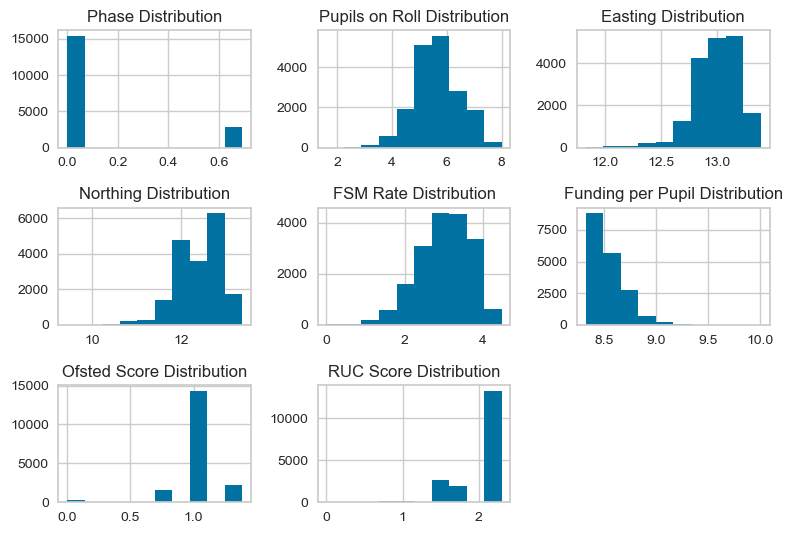

In [609]:
# plot distribution of transformed X to confirm improved normality
draw_histograms(X_log, X_log.columns, 3, 3)

In [610]:
# split data into train and test groups (30% train)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.3, random_state=42)

In [611]:
# create regression tree model and train on train data
model_log = DecisionTreeRegressor(random_state=42)
model_log.fit(X_log_train,y_log_train)

DecisionTreeRegressor(random_state=42)

In [612]:
# use the trained model to make predictions for absence rates in X_test
predictions_log = model_log.predict(X_log_test)
predictions_log

array([1.65824522, 1.86199734, 1.58202149, ..., 1.76898543, 1.63065914,
       2.52388855])

In [616]:
log_mse = mean_squared_error(y_log_test, predictions_log)
log_rmse = mean_squared_error(y_log_test, predictions_log, squared=False)

print('MSE:',log_mse,'RMSE:',log_rmse)

MSE: 0.08922207764237994 RMSE: 0.2987006488817524


In [617]:
pd.Series({'Original MSE': mse,
               'Log transformed MSE': log_mse,
               'Original RMSE': rmse,
               'Log transformed RMSE': log_rmse,
              })

Original MSE            3.807247
Log transformed MSE     0.089222
Original RMSE           1.951217
Log transformed RMSE    0.298701
dtype: float64

The MSE and RMSE for the transformed data are lower, suggesting an improved fit for this model. 